In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [18]:
df = pd.read_csv('../data/consolidated_data/training_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df = pd.get_dummies(df, columns=['state'])

In [19]:
df.head()

,date,cases_new,cases_recovered,cases_active,cases_unvax,cases_pvax,cases_fvax,cases_0_4,cases_5_11,cases_12_17,...,state_Perak,state_Perlis,state_Pulau Pinang,state_Sabah,state_Sarawak,state_Selangor,state_Terengganu,state_W.P. Kuala Lumpur,state_W.P. Labuan,state_W.P. Putrajaya
0,2020-01-25,4,0,4,4,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,2020-01-25,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,2020-01-25,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,2020-01-25,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cases_new'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}' )
print(f'Critical Values: {result[4]}')

ADF Statistic: -2.405630620507177
p-value: 0.14015351027001127
Critical Values: {'1%': -3.4306145729682744, '5%': -2.861656933183008, '10%': -2.5668322401244907}


In [21]:
split_index = int(0.8 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

Training data shape: (19814, 43)
Testing data shape: (4954, 43)              date  cases_new  cases_recovered  cases_active  cases_unvax  \
19814  2023-06-16         38               45           782            4   
19815  2023-06-16          4                3            93            1   
19816  2023-06-16         48               39           605            2   
19817  2023-06-16         17                5          3791            2   
19818  2023-06-16         45               56           686           10   
...           ...        ...              ...           ...          ...   
24763  2024-04-20         39                8            37            4   
24764  2024-04-20          0                0           299            0   
24765  2024-04-20         33                5           585            6   
24766  2024-04-20          0                0            28            0   
24767  2024-04-20          3                0           240            0   

       cases_pvax  case

---

In [22]:
from statsmodels.tsa.arima.model import ARIMA
train_data = train_data.set_index('date')
test_data = test_data.set_index('date')

In [23]:
train_data.info()    

<class 'pandas.core.frame.DataFrame'>
Index: 19814 entries, 2020-01-25 to 2023-06-16
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cases_new                  19814 non-null  int64  
 1   cases_recovered            19814 non-null  int64  
 2   cases_active               19814 non-null  int64  
 3   cases_unvax                19814 non-null  int64  
 4   cases_pvax                 19814 non-null  int64  
 5   cases_fvax                 19814 non-null  int64  
 6   cases_0_4                  19814 non-null  int64  
 7   cases_5_11                 19814 non-null  int64  
 8   cases_12_17                19814 non-null  int64  
 9   cases_18_29                19814 non-null  int64  
 10  cases_30_39                19814 non-null  int64  
 11  cases_40_49                19814 non-null  int64  
 12  cases_50_59                19814 non-null  int64  
 13  cases_60_69                19814 non-

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19814 entries, 2020-01-25 to 2023-06-16
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cases_new                  19814 non-null  int64  
 1   cases_recovered            19814 non-null  int64  
 2   cases_active               19814 non-null  int64  
 3   cases_unvax                19814 non-null  int64  
 4   cases_pvax                 19814 non-null  int64  
 5   cases_fvax                 19814 non-null  int64  
 6   cases_0_4                  19814 non-null  int64  
 7   cases_5_11                 19814 non-null  int64  
 8   cases_12_17                19814 non-null  int64  
 9   cases_18_29                19814 non-null  int64  
 10  cases_30_39                19814 non-null  int64  
 11  cases_40_49                19814 non-null  int64  
 12  cases_50_59                19814 non-null  int64  
 13  cases_60_69                19814 non-

In [25]:
for columns in train_data.columns:
    train_data[columns] = train_data[columns].astype('float64')
    

In [26]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19814 entries, 2020-01-25 to 2023-06-16
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cases_new                  19814 non-null  float64
 1   cases_recovered            19814 non-null  float64
 2   cases_active               19814 non-null  float64
 3   cases_unvax                19814 non-null  float64
 4   cases_pvax                 19814 non-null  float64
 5   cases_fvax                 19814 non-null  float64
 6   cases_0_4                  19814 non-null  float64
 7   cases_5_11                 19814 non-null  float64
 8   cases_12_17                19814 non-null  float64
 9   cases_18_29                19814 non-null  float64
 10  cases_30_39                19814 non-null  float64
 11  cases_40_49                19814 non-null  float64
 12  cases_50_59                19814 non-null  float64
 13  cases_60_69                19814 non-

In [100]:
from statsmodels.tsa.arima.model import ARIMA
ARIMAModel = ARIMA(train_data['cases_new'],order=(2,3,3))
fitted_ARIMAModel = ARIMAModel.fit()

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameter

In [101]:
forecastArima = fitted_ARIMAModel.forecast(steps=len(test_data))

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [102]:
df_vis = test_data.copy()
df_vis['cases_new'] = forecastArima.values

In [103]:
df_vis.index = pd.to_datetime(df_vis.index)

In [104]:
df_vis['cases_new']

date
2023-06-16         3.032709
2023-06-16        25.477051
2023-06-16         3.499985
2023-06-16        33.772740
2023-06-16         7.339147
                  ...      
2024-04-20   -964248.563671
2024-04-20   -964667.409920
2024-04-20   -965033.913502
2024-04-20   -965452.917870
2024-04-20   -965819.582999
Name: cases_new, Length: 4954, dtype: float64

In [105]:
df['cases_new']

0         4
1         0
2         0
3         0
4         0
         ..
24763    39
24764     0
24765    33
24766     0
24767     3
Name: cases_new, Length: 24768, dtype: int64

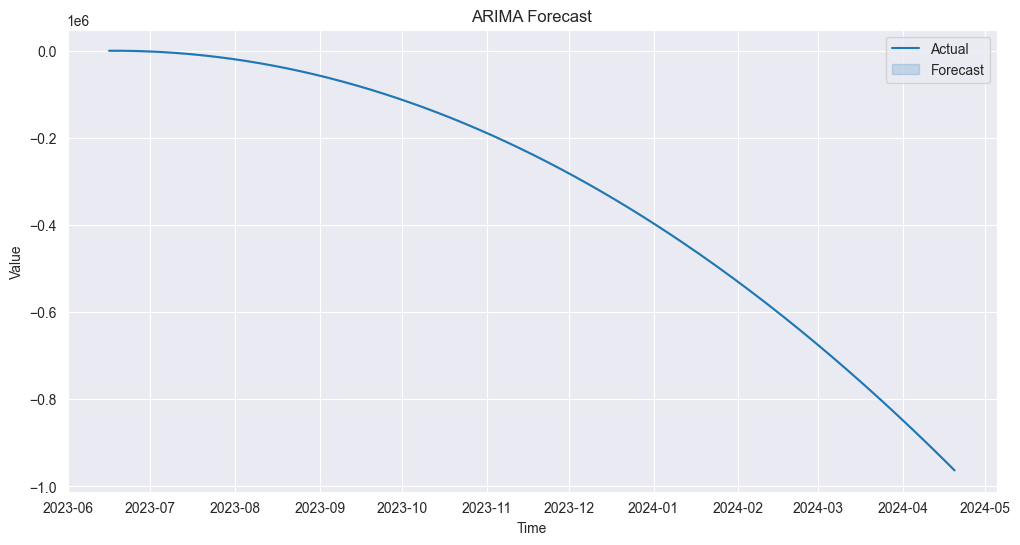

In [106]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_vis['cases_new'],label='Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend(['Actual', 'Forecast'])
plt.show()